# Game of NIM

(See Readme for detail and results.)

Import some libraries

In [1]:
import numpy as np
import pickle
import math
import matplotlib.pyplot as plt

# Class State

## Methods:
- initial board
- getHash
- available moves
- update states
- rewards and winner
- plot win games
- show board


In [2]:
class State:
    def __init__(self, number_rows = 5):
        self.number_rows = number_rows
        self.board = np.arange(1,self.number_rows+1)
        ### for example, if number_rows = 5 as default, this is the initial board:
        #   O
        #   O O
        #   O O O 
        #   O O O O
        #   O O O O O
        
        # flag for END game
        self.isEnd = False
        # Hash key for board
        self.boardHash = None
        # init p1 plays first
        self.playerSymbol = 1

    # get unique hash of current board state
    def getHash(self):
        self.boardHash = str(self.board)
        return self.boardHash

    # winner-control
    def winner(self):
        if np.sum(self.board) == 0:
            self.isEnd = True
            return 1 if self.playerSymbol == 1 else -1
        else:
            # not end
            self.isEnd = False
            return None

    # return the available moves given the current board
    def availableMoves(self):
        moves = []
        for i in range(self.number_rows):
            if self.board[i] != 0: # just if the row is not empty
                for j in range(self.board[i]):
                    # how many "O" we have in row i 
                    moves.append((i, j+1))  # need to be tuple
        return moves
    
    # update the current board with the move
    def updateState(self, move):
        row = move[0]
        num = move[1]
        self.board[row] = self.board[row]-num
        # resort the board to try to keep small the different states
        self.board = np.sort(self.board)
        

    # gives reward (only when game ends)
    def giveReward(self, p1, p2):
        # select the player who win
        result = self.winner()
        # backpropagate reward
        if result == 1:
            p1.feedReward(1) # 1 for win, -1 for loss
            p1.win_games.append(1)
            p2.feedReward(-1)
            p2.win_games.append(-1)
        else:
            p1.feedReward(-1)
            p1.win_games.append(-1)
            p2.feedReward(1)
            p2.win_games.append(1)
        
    # board reset
    def reset(self):
        self.board = np.arange(1,self.number_rows+1)
        
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1
        
    # print the current board                
    def showBoard(self):
        skip = 0
        print('--------------')
        for i in range(self.number_rows):
            if self.board[i] > 0:
                out = ' '
                out += str(i+1 - skip)
                out += ' '
                for j in range(self.board[i]):
                    out += '# '
                print(out)
            else: # print just the rows not empty
                skip += 1
        print('-------------')
        
    ### after all the rounds, plot the mean rewards ###
    def plot_rewards(self, p1, p2, num_rows):
        avg_rew_1 = []
        avg_rew_2 = []
        
        n = min(len(p1.win_games), len(p2.win_games))
        
        for i in (range(n)):
            avg_rew_1.append(np.mean(p1.win_games[max(0, i-1000):(i+1)]))
            avg_rew_2.append(np.mean(p2.win_games[max(0, i-1000):(i+1)]))
        
        plt.plot(avg_rew_1, label = 'p1')
        plt.plot(avg_rew_2, label = 'p2')
        plt.axhline(y=1, xmin=0, xmax=n)#, label = "1")
        plt.axhline(y=-1, xmin=0, xmax=n)#, label = "-1")
        plt.legend()
        # save the figure in output_avg_reward_'num_rows'.pdf
        string_fig = 'output_avg_reward_' + str(num_rows) + '.pdf'
        plt.savefig(string_fig)

# Classes of Player (computer) and HumanPlayer

## Methods:
- choose action
- add state
- feed reward
- save and load policy
- load policy from lower cases

In [3]:
# Computer Player
class Player:
    def __init__(self, name, learning_rate = 0.5, exp_rate = 0.99, decay_rate = 5, decay_gamma = 0.99, epsilon_min = 0.05):
        self.name = name
        self.states = []  # record all positions taken
        # parameters for epsilon search
        self.lr = learning_rate
        self.exp_rate = exp_rate
        self.decay_rate = decay_rate
        self.decay_gamma = decay_gamma
        self.epsilon_min = epsilon_min
        # Q-Learning MAP
        self.states_value = {}  # state -> value 
        # collect all the results
        self.win_games = []

    # get the Hash key for current board    
    def getHash(self, board):
        boardHash = str(board)
        return boardHash

    def chooseAction(self, moves, current_board, symbol, episode):

        # if our random unif > epsilon
        if np.random.uniform(0, 1) >= max(self.epsilon_min, (self.exp_rate * math.exp(-episode*self.decay_rate))):
            
            value_max = -999
            
            # select all the possible moves
            for p in moves:
                next_board = current_board.copy()
                row = p[0]
                num = p[1]
                next_board[row] = next_board[row]-num

                next_board = np.sort(next_board)

                next_boardHash = self.getHash(next_board)
                
                # collect the value of next move
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                
                # select the best move
                if value >= value_max:
                    value_max = value
                    action = p
        else:
            # random initialization
            idx = np.random.choice(len(moves))
            action = moves[idx] # take random action
                    
        return action

    # append a hash state
    def addState(self, state):
        self.states.append(state)

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        initial_reward = reward
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            # Bellmann Equation    
            self.states_value[st] += self.lr * (initial_reward + self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]
            

    # reset the states        
    def reset(self):
        self.states = []

    # save the current policy (after the training part)    
    def savePolicy(self, n):
        fw = open('policy_' + str(self.name) + '_' + str(n), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    # load the policy to play against human    
    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()
        
    # load the policy to play against human    
    def loadPolicy_from_previous_cases(self, file, n_previous_cases, n_rows):
        fr = open(file, 'rb')
        tmp = pickle.load(fr)
        fr.close()
        zeros_add = n_rows - n_previous_cases
        
        tmp_copy = tmp.copy()
        
        zeros_string = ''
        for i in range(zeros_add):
            if i == 0:
                zeros_string += '[0 '
            else:
                zeros_string += '0 '
        
        for k, v in tmp_copy.items():
            new_key = zeros_string + k[1:]
            tmp[new_key] = tmp.pop(k)
        
        self.states_value = tmp

# Human Player
class HumanPlayer:
    def __init__(self, name):
        self.name = name

    # human choose action    
    def chooseAction(self, moves, skip):
        while True:
            # collect action: row and num
            row = int(input("Input your action row:"))
            num = int(input("Input your action num:"))
            # put it in the right position
            action = (row - 1 + skip, num)
            # if the action is available, else request another action
            if action in moves:
                return action

    # append a hash state
    def addState(self, state):
        pass

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass

    def reset(self):
        pass

# Class NIM

## Methods:
- learn_from_previous_cases
- learn
- play_with_human

In [4]:
class Nim:
    def __init__(self, State, p1, p2):
        self.State = State
        self.p1 = p1
        self.p2 = p2
        
    def learn_from_previous_cases(self, num_rows_previous_case, rounds):
        n = num_rows_previous_case
        str1 = 'policy_p1_' + str(n)
        str2 = 'policy_p2_' + str(n)
        
        if(n == self.State.number_rows):
            self.p1.loadPolicy(str1)
            self.p2.loadPolicy(str2)
        elif(n < self.State.number_rows):
            self.p1.loadPolicy_from_previous_cases(str1, n, self.State.number_rows)
            self.p2.loadPolicy_from_previous_cases(str2, n, self.State.number_rows)
            self.learn(rounds)

    # play a game between two computer    
    def learn(self, rounds=10000):
        
        for i in range(rounds): # number of games    
            
            # loading
            if i % (round(rounds/10)) == 0:
                print(int(100*i/rounds), "%")
                
            # while the game has not ended    
            while not self.State.isEnd:
                
                ### Player 1 turn ###
                
                # available moves for the current board
                moves = self.State.availableMoves()
                # choose the best action for the current board
                p1_action = self.p1.chooseAction(moves, self.State.board, self.State.playerSymbol, i/rounds)
                # take action and update board state
                self.State.updateState(p1_action)
                # take and add the Hash key for this state
                board_hash = self.State.getHash()
                self.p1.addState(board_hash)
                
                # check board status if it is end
                win = self.State.winner()
                if win is not None:
                    # game ended, give the reward
                    self.State.giveReward(self.p1, self.p2)
                    self.p1.reset()
                    self.p2.reset()
                    # reset the game
                    self.State.reset()
                    # another round
                    break

                else:
                    # switch to player 2
                    self.State.playerSymbol = -1
                    
                    ### Player 2 turn ###
                    
                    # available moves for the current board
                    moves = self.State.availableMoves()
                    # choose the best action for the current board
                    p2_action = self.p2.chooseAction(moves, self.State.board, self.State.playerSymbol, i/rounds)
                    # take action and update board state
                    self.State.updateState(p2_action)
                    # take and add the Hash key for this state
                    board_hash = self.State.getHash()
                    self.p2.addState(board_hash)

                    # check board status if it is end
                    win = self.State.winner()
                    if win is not None:
                        # game ended, give the reward
                        self.State.giveReward(self.p1,self.p2)
                        self.p1.reset()
                        self.p2.reset()
                        # reset the game
                        self.State.reset()
                        # another round
                        break
                        
                    # switch to player 1
                    self.State.playerSymbol = 1

        self.State.plot_rewards(self.p1, self.p2, self.State.number_rows)


    # play with human
    def play_with_human(self):
        print('---- Initial Board ----')
        self.State.showBoard()
        # while the game has not ended  
        while not self.State.isEnd:
            
            ### Player 1 (computer) ###
            print('---- Computer turn ------')
            # available moves for the current board
            moves = self.State.availableMoves()
            # choose the best action for the current board
            p1_action = self.p1.chooseAction(moves, self.State.board, self.State.playerSymbol, 1)
            # take action and upate board state
            self.State.updateState(p1_action)
            self.State.showBoard()
            
            # check board status if it is end
            win = self.State.winner()
            if win is not None:
                # print "computer wins"
                print(self.p1.name, "wins!")
                self.State.reset()
                break

            else:
                
                ### Player 2 (Human) ###
                
                print('---- Human turn ------')
                # available moves for the current board
                moves = self.State.availableMoves()
                # number of rows empty
                skip = sum(self.State.board == 0)
                # ask the human player which action takes
                p2_action = self.p2.chooseAction(moves, skip)
                
                # take action and upate board state
                self.State.updateState(p2_action)
                self.State.showBoard()
                
                # check board status if it is end
                win = self.State.winner()
                if win is not None:
                    # print "human wins"
                    print(self.p2.name, "wins!")
                    self.State.reset()
                    break

# Training

Training in a Q-Learning Agent vs Q-Learning Agent environment. Print the avg_reward in "output_avg_reward.pdf".

(Not run if you just want to play, skip to the next cell!)

training...
0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


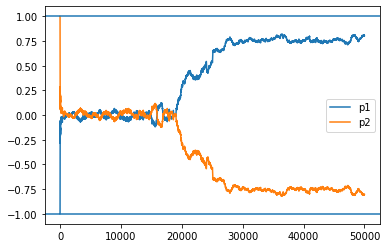

In [5]:
n_games = 50000

# 2 computer player
p1 = Player("p1") # default parameters
p2 = Player("p2")

# number of rows
n_rows = 5

# build the board state
st = State(n_rows)

# build the game
nim = Nim(st, p1, p2)

# play n_games
print("training...")
nim.learn(n_games)

# save the policy
p1.savePolicy(n_rows)
p2.savePolicy(n_rows)

# Let's play!

Play against the computer with policy "policy_p1_5" (nrows = 5)

In [6]:
n_rows = 5

# computer player, exp_rate = 0 because now we don't 
# need to learn
p3 = Player("computer", exp_rate=0, epsilon_min = 0)
# load a policy
p3.loadPolicy("policy_p1_5")

# human player
p4 = HumanPlayer("human")

# play against computer!
st_2 = State(n_rows)

nim_with_human = Nim(st_2,p3,p4)
nim_with_human.play_with_human()

---- Initial Board ----
--------------
 1 # 
 2 # # 
 3 # # # 
 4 # # # # 
 5 # # # # # 
-------------
---- Computer turn ------
--------------
 1 # 
 2 # # 
 3 # # 
 4 # # # # 
 5 # # # # # 
-------------
---- Human turn ------


Input your action row: 5
Input your action num: 2


--------------
 1 # 
 2 # # 
 3 # # 
 4 # # # 
 5 # # # # 
-------------
---- Computer turn ------
--------------
 1 # 
 2 # # 
 3 # # 
 4 # # 
 5 # # # 
-------------
---- Human turn ------


Input your action row: 4
Input your action num: 2


--------------
 1 # 
 2 # # 
 3 # # 
 4 # # # 
-------------
---- Computer turn ------
--------------
 1 # 
 2 # 
 3 # # 
 4 # # 
-------------
---- Human turn ------


Input your action row: 1
Input your action num: 1


--------------
 1 # 
 2 # # 
 3 # # 
-------------
---- Computer turn ------
--------------
 1 # # 
 2 # # 
-------------
---- Human turn ------


Input your action row: 2
Input your action num: 1


--------------
 1 # 
 2 # # 
-------------
---- Computer turn ------
--------------
 1 # 
 2 # 
-------------
---- Human turn ------


Input your action row: 1
Input your action num: 1


--------------
 1 # 
-------------
---- Computer turn ------
--------------
-------------
computer wins!


# Learn from smaller games

We can use policy from learning-rounds of small number_rows (i.e. 3) for learning in bigger number_rows cases.

training...
0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %


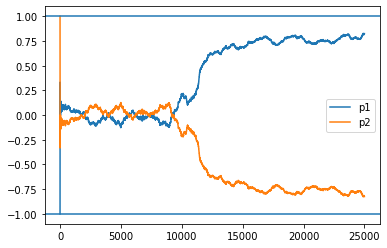

In [9]:
# try for example with half of the number n_games
n_games = 25000

# 2 computer player
p1 = Player("p1_half")
p2 = Player("p2_half")

# build the game
st = State(5)

nim_from3 = Nim(st,p1,p2)

# play n_games
print("training...")
nim_from3.learn_from_previous_cases(3,n_games)